나이브 베이즈 분석 및 데이터 품질 평가 시작!
특성 데이터: (2500, 70)
타겟 데이터: (2500, 5)
특성 목록 (일부): ['first_purchase_day', 'last_purchase_day', 'purchase_days', 'total_sales', 'avg_sales', 'std_sales', 'total_transactions', 'total_quantity', 'avg_quantity', 'total_visits']
=== 데이터 품질 1차 평가 ===

특성 데이터 기본 정보:
  샘플 수: 2,500
  특성 수: 70
  결측값: 0

특성별 통계 요약:
  평균의 평균: 597.37
  표준편차의 평균: 1176.75

높은 상관관계 (|r| > 0.8) 특성 쌍: 64개
  last_purchase_day ↔ recency: -1.000
  last_purchase_day ↔ customer_lifetime_days: 0.851
  purchase_days ↔ total_sales: 0.965
  purchase_days ↔ total_transactions: 1.000
  purchase_days ↔ monetary: 0.965
=== 나이브 베이즈 모델 성능 평가 ===

--- high_value_monetary 분석 ---
클래스 분포: {0: np.float64(0.8), 1: np.float64(0.2)}
  Gaussian: 정확도=0.996, AUC=1.000, CV=0.998±0.002
  Multinomial: 정확도=0.910, AUC=0.969, CV=0.907±0.014
  Bernoulli: 정확도=0.888, AUC=0.957, CV=0.879±0.019

--- high_value_frequency 분석 ---
클래스 분포: {0: np.float64(0.7988), 1: np.float64(0.2012)}
  Gaussian: 정확도=0.950, AUC=0.979, CV=0.952±0.009
 

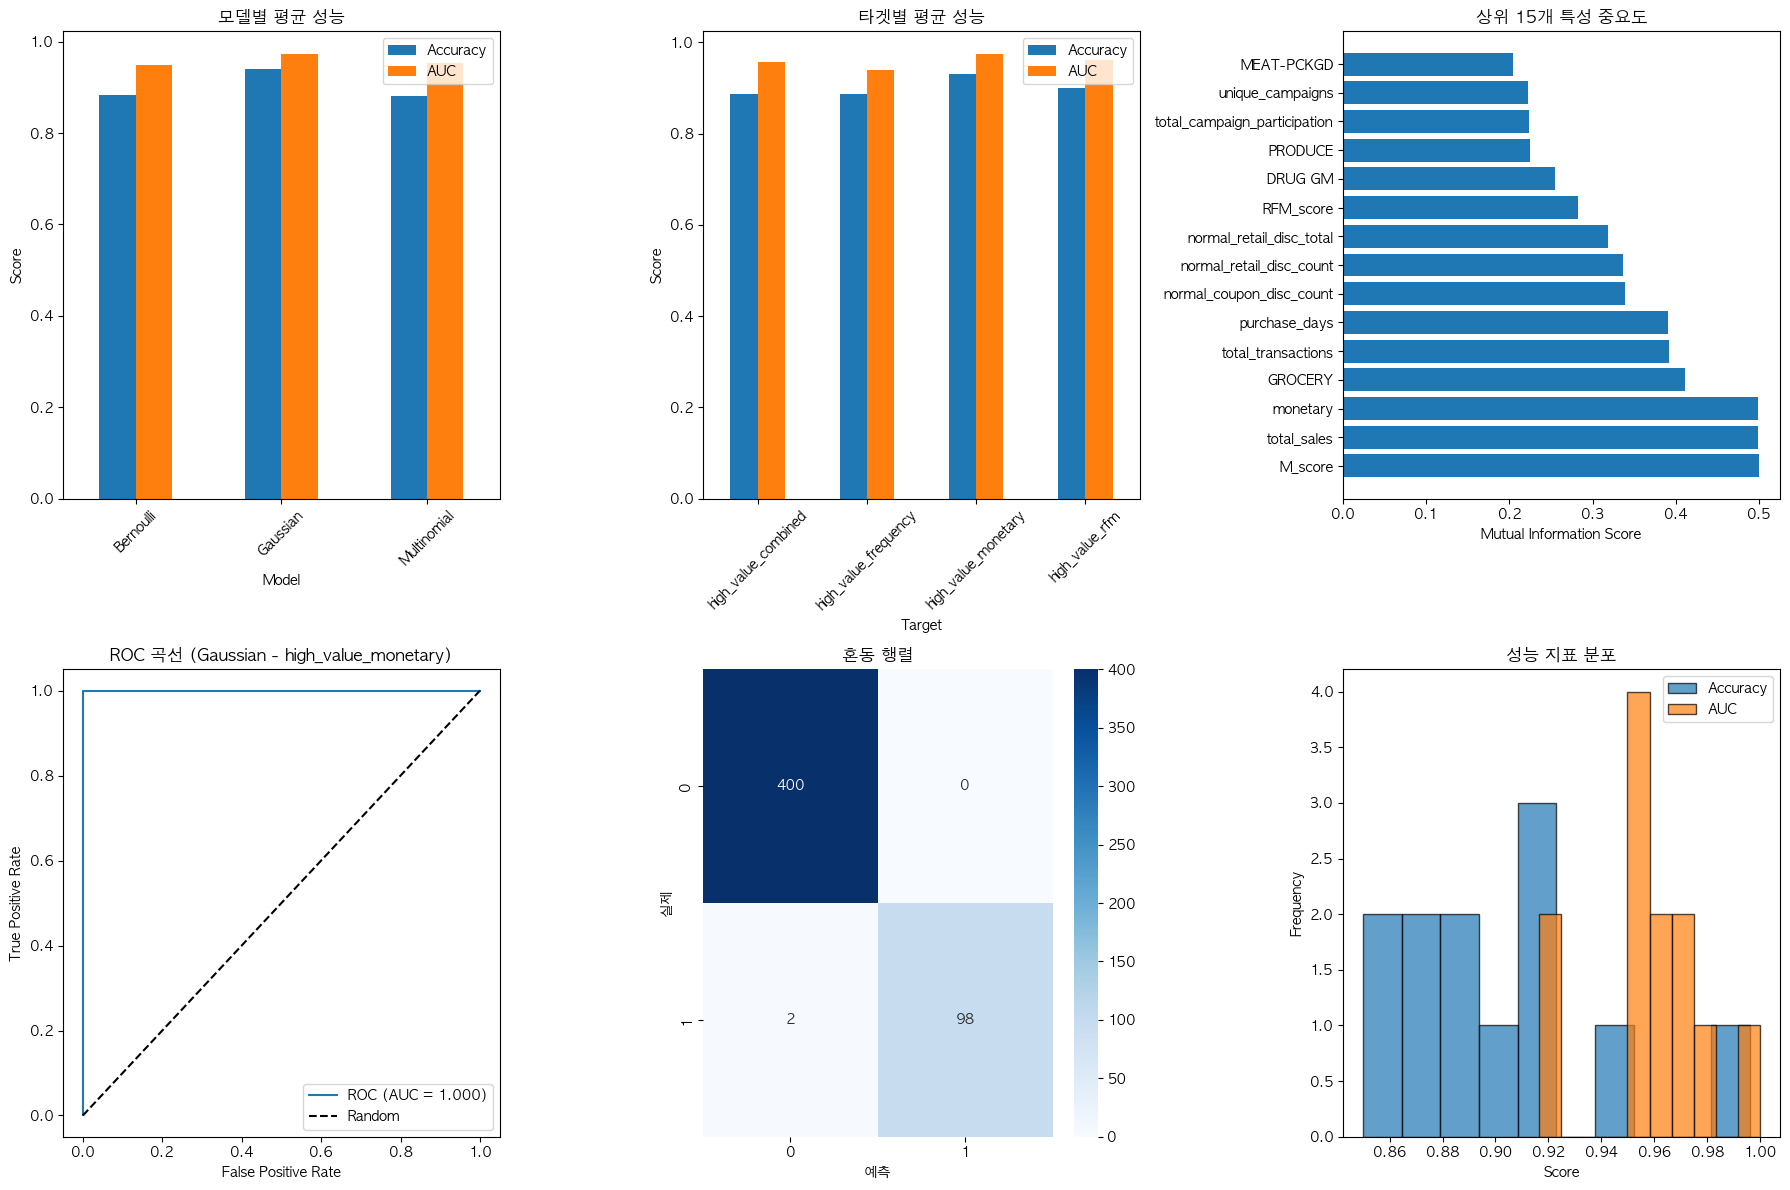

=== 나이브 베이즈 가정 검증 ===

특성 독립성 가정 검증:
높은 상관관계 특성 쌍: 64개
⚠️ 많은 특성들이 높은 상관관계를 보임 - 독립성 가정 위배 가능

정규성 검증 (상위 5개 특성):
  M_score: 정규분포 X (p=0.000)
  total_sales: 정규분포 X (p=0.000)
  monetary: 정규분포 X (p=0.000)
  GROCERY: 정규분포 X (p=0.000)
  total_transactions: 정규분포 X (p=0.000)
=== 최종 분석 결과 및 권장사항 ===

1. 데이터 품질 종합 평가: 9/9점
2. 최고 성능 조합: Gaussian + high_value_monetary
3. 최고 AUC: 1.000
4. 평균 정확도: 0.901

권장사항:
✅ 현재 데이터로 나이브 베이즈 분석 진행 가능
✅ 할인 레코드 포함이 모델 성능에 도움됨

상위 3개 중요 특성: M_score, total_sales, monetary

결과 저장 완료:
  성능 결과: naive_bayes_performance.csv
  특성 중요도: feature_importance.csv
  최고 모델: best_naive_bayes_model.pkl

=== 나이브 베이즈 분석 완료 ===


In [2]:
# %%
# 나이브 베이즈 분석 및 데이터 품질 평가
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import mutual_info_classif, SelectKBest
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

print("나이브 베이즈 분석 및 데이터 품질 평가 시작!")

# %%
# 1. 특성 데이터 로딩

features_path = '../data/features/'

# 피처 엔지니어링 결과 로딩
X = pd.read_csv(f'{features_path}features_X_v2.csv', index_col=0)
targets = pd.read_csv(f'{features_path}targets_y_v2.csv')

print(f"특성 데이터: {X.shape}")
print(f"타겟 데이터: {targets.shape}")
print(f"특성 목록 (일부): {list(X.columns[:10])}")

# %%
# 2. 데이터 품질 1차 평가 - 기본 통계

print("=== 데이터 품질 1차 평가 ===")

# 2-1. 특성별 기본 통계
print("\n특성 데이터 기본 정보:")
print(f"  샘플 수: {len(X):,}")
print(f"  특성 수: {len(X.columns)}")
print(f"  결측값: {X.isnull().sum().sum()}")

# 2-2. 특성 분포 확인
print("\n특성별 통계 요약:")
feature_stats = X.describe()
print(f"  평균의 평균: {feature_stats.loc['mean'].mean():.2f}")
print(f"  표준편차의 평균: {feature_stats.loc['std'].mean():.2f}")

# 2-3. 상관관계 분석
correlation_matrix = X.corr()
high_corr_pairs = []
n_features = len(X.columns)

for i in range(n_features):
    for j in range(i+1, n_features):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.8:  # 높은 상관관계
            high_corr_pairs.append((X.columns[i], X.columns[j], corr_val))

print(f"\n높은 상관관계 (|r| > 0.8) 특성 쌍: {len(high_corr_pairs)}개")
if len(high_corr_pairs) > 0:
    for feat1, feat2, corr in high_corr_pairs[:5]:
        print(f"  {feat1} ↔ {feat2}: {corr:.3f}")

# %%
# 3. 타겟 변수별 나이브 베이즈 모델 성능 평가

print("=== 나이브 베이즈 모델 성능 평가 ===")

target_columns = ['high_value_monetary', 'high_value_frequency', 'high_value_combined', 'high_value_rfm']
nb_models = {
    'Gaussian': GaussianNB(),
    'Multinomial': MultinomialNB(),
    'Bernoulli': BernoulliNB()
}

# 결과 저장용
results = {}

for target_name in target_columns:
    print(f"\n--- {target_name} 분석 ---")
    y = targets[target_name]
    
    # 클래스 분포 확인
    class_dist = y.value_counts(normalize=True)
    print(f"클래스 분포: {dict(class_dist)}")
    
    # 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    target_results = {}
    
    for model_name, model in nb_models.items():
        try:
            # 데이터 전처리 (모델별)
            if model_name == 'Multinomial':
                # Multinomial은 음수 값을 허용하지 않음
                scaler = MinMaxScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)
            elif model_name == 'Gaussian':
                # Gaussian은 스케일링이 도움됨
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)
            else:  # Bernoulli
                # Bernoulli는 이진 특성 선호
                scaler = MinMaxScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)
                # 0.5 기준으로 이진화
                X_train_scaled = (X_train_scaled > 0.5).astype(int)
                X_test_scaled = (X_test_scaled > 0.5).astype(int)
            
            # 모델 훈련
            model.fit(X_train_scaled, y_train)
            
            # 예측
            y_pred = model.predict(X_test_scaled)
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
            
            # 성능 평가
            accuracy = model.score(X_test_scaled, y_test)
            auc_score = roc_auc_score(y_test, y_pred_proba)
            
            # 교차 검증
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
            
            target_results[model_name] = {
                'accuracy': accuracy,
                'auc': auc_score,
                'cv_mean': cv_scores.mean(),
                'cv_std': cv_scores.std(),
                'y_test': y_test,
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba
            }
            
            print(f"  {model_name}: 정확도={accuracy:.3f}, AUC={auc_score:.3f}, CV={cv_scores.mean():.3f}±{cv_scores.std():.3f}")
            
        except Exception as e:
            print(f"  {model_name}: 오류 발생 - {str(e)}")
            target_results[model_name] = None
    
    results[target_name] = target_results

# %%
# 4. 데이터 품질 평가 - 나이브 베이즈 성능 기반

print("=== 데이터 품질 평가 (나이브 베이즈 성능 기반) ===")

# 4-1. 전체 성능 요약
performance_summary = []

for target_name, target_results in results.items():
    for model_name, result in target_results.items():
        if result is not None:
            performance_summary.append({
                'Target': target_name,
                'Model': model_name,
                'Accuracy': result['accuracy'],
                'AUC': result['auc'],
                'CV_Mean': result['cv_mean'],
                'CV_Std': result['cv_std']
            })

performance_df = pd.DataFrame(performance_summary)

print("\n성능 요약:")
print(performance_df.groupby('Model')[['Accuracy', 'AUC', 'CV_Mean']].mean().round(3))

# 4-2. 데이터 품질 판정 기준
print("\n=== 데이터 품질 판정 ===")

avg_accuracy = performance_df['Accuracy'].mean()
avg_auc = performance_df['AUC'].mean()
avg_cv_std = performance_df['CV_Std'].mean()

print(f"평균 정확도: {avg_accuracy:.3f}")
print(f"평균 AUC: {avg_auc:.3f}")
print(f"평균 CV 표준편차: {avg_cv_std:.3f}")

# 데이터 품질 판정
quality_score = 0
quality_comments = []

if avg_accuracy > 0.75:
    quality_score += 3
    quality_comments.append("✅ 높은 분류 성능 (정확도 > 75%)")
elif avg_accuracy > 0.65:
    quality_score += 2
    quality_comments.append("🔶 중간 분류 성능 (정확도 65-75%)")
else:
    quality_score += 1
    quality_comments.append("❌ 낮은 분류 성능 (정확도 < 65%)")

if avg_auc > 0.8:
    quality_score += 3
    quality_comments.append("✅ 높은 구분력 (AUC > 0.8)")
elif avg_auc > 0.7:
    quality_score += 2
    quality_comments.append("🔶 중간 구분력 (AUC 0.7-0.8)")
else:
    quality_score += 1
    quality_comments.append("❌ 낮은 구분력 (AUC < 0.7)")

if avg_cv_std < 0.05:
    quality_score += 3
    quality_comments.append("✅ 안정적 성능 (CV 표준편차 < 0.05)")
elif avg_cv_std < 0.1:
    quality_score += 2
    quality_comments.append("🔶 보통 안정성 (CV 표준편차 0.05-0.1)")
else:
    quality_score += 1
    quality_comments.append("❌ 불안정한 성능 (CV 표준편차 > 0.1)")

print(f"\n데이터 품질 점수: {quality_score}/9")
for comment in quality_comments:
    print(f"  {comment}")

if quality_score >= 8:
    print("\n🎉 데이터 품질: 우수 - 신뢰할 수 있는 분석 가능")
elif quality_score >= 6:
    print("\n👍 데이터 품질: 양호 - 분석 가능하나 개선 여지 있음")
elif quality_score >= 4:
    print("\n⚠️ 데이터 품질: 보통 - 추가 전처리 권장")
else:
    print("\n❌ 데이터 품질: 불량 - 데이터 개선 필요")

# %%
# 5. 특성 중요도 분석

print("=== 특성 중요도 분석 ===")

# 최고 성능 타겟 선택
best_target = performance_df.loc[performance_df['AUC'].idxmax(), 'Target']
print(f"최고 성능 타겟: {best_target}")

y_best = targets[best_target]

# Mutual Information으로 특성 중요도 계산
mi_scores = mutual_info_classif(X, y_best, random_state=42)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': mi_scores
}).sort_values('importance', ascending=False)

print("\n상위 10개 중요 특성:")
print(feature_importance.head(10))

# %%
# 6. 시각화

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 6-1. 모델별 성능 비교
model_performance = performance_df.groupby('Model')[['Accuracy', 'AUC']].mean()
model_performance.plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('모델별 평균 성능')
axes[0,0].set_ylabel('Score')
axes[0,0].legend()
axes[0,0].tick_params(axis='x', rotation=45)

# 6-2. 타겟별 성능 비교
target_performance = performance_df.groupby('Target')[['Accuracy', 'AUC']].mean()
target_performance.plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('타겟별 평균 성능')
axes[0,1].set_ylabel('Score')
axes[0,1].legend()
axes[0,1].tick_params(axis='x', rotation=45)

# 6-3. 특성 중요도 상위 15개
top_features = feature_importance.head(15)
axes[0,2].barh(range(len(top_features)), top_features['importance'])
axes[0,2].set_yticks(range(len(top_features)))
axes[0,2].set_yticklabels(top_features['feature'])
axes[0,2].set_title('상위 15개 특성 중요도')
axes[0,2].set_xlabel('Mutual Information Score')

# 6-4. ROC 곡선 (최고 성능 모델)
best_model_name = performance_df.loc[performance_df['AUC'].idxmax(), 'Model']
best_result = results[best_target][best_model_name]

if best_result:
    fpr, tpr, _ = roc_curve(best_result['y_test'], best_result['y_pred_proba'])
    axes[1,0].plot(fpr, tpr, label=f'ROC (AUC = {best_result["auc"]:.3f})')
    axes[1,0].plot([0, 1], [0, 1], 'k--', label='Random')
    axes[1,0].set_xlabel('False Positive Rate')
    axes[1,0].set_ylabel('True Positive Rate')
    axes[1,0].set_title(f'ROC 곡선 ({best_model_name} - {best_target})')
    axes[1,0].legend()

# 6-5. 혼동 행렬
if best_result:
    cm = confusion_matrix(best_result['y_test'], best_result['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[1,1], cmap='Blues')
    axes[1,1].set_title('혼동 행렬')
    axes[1,1].set_xlabel('예측')
    axes[1,1].set_ylabel('실제')

# 6-6. 성능 분포
axes[1,2].hist(performance_df['Accuracy'], bins=10, alpha=0.7, label='Accuracy', edgecolor='black')
axes[1,2].hist(performance_df['AUC'], bins=10, alpha=0.7, label='AUC', edgecolor='black')
axes[1,2].set_title('성능 지표 분포')
axes[1,2].set_xlabel('Score')
axes[1,2].set_ylabel('Frequency')
axes[1,2].legend()

plt.tight_layout()
plt.show()

# %%
# 7. 나이브 베이즈 가정 검증

print("=== 나이브 베이즈 가정 검증 ===")

# 7-1. 특성 독립성 가정 검증
print("\n특성 독립성 가정 검증:")
print(f"높은 상관관계 특성 쌍: {len(high_corr_pairs)}개")

if len(high_corr_pairs) > 10:
    print("⚠️ 많은 특성들이 높은 상관관계를 보임 - 독립성 가정 위배 가능")
elif len(high_corr_pairs) > 5:
    print("🔶 일부 특성들이 상관관계를 보임 - 주의 필요")
else:
    print("✅ 대부분 특성들이 독립적 - 가정 만족")

# 7-2. 정규성 가정 검증 (Gaussian NB용)
from scipy.stats import shapiro

print("\n정규성 검증 (상위 5개 특성):")
top_5_features = feature_importance.head(5)['feature'].values

for feature in top_5_features:
    _, p_value = shapiro(X[feature].sample(min(5000, len(X))))  # 샘플링으로 테스트
    if p_value > 0.05:
        print(f"  {feature}: 정규분포 O (p={p_value:.3f})")
    else:
        print(f"  {feature}: 정규분포 X (p={p_value:.3f})")

# %%
# 8. 최종 권장사항

print("=== 최종 분석 결과 및 권장사항 ===")

print(f"\n1. 데이터 품질 종합 평가: {quality_score}/9점")
print(f"2. 최고 성능 조합: {best_model_name} + {best_target}")
print(f"3. 최고 AUC: {performance_df['AUC'].max():.3f}")
print(f"4. 평균 정확도: {avg_accuracy:.3f}")

print("\n권장사항:")
if quality_score >= 7:
    print("✅ 현재 데이터로 나이브 베이즈 분석 진행 가능")
    print("✅ 할인 레코드 포함이 모델 성능에 도움됨")
elif quality_score >= 5:
    print("🔶 추가 피처 엔지니어링으로 성능 개선 가능")
    print("🔶 특성 선택 또는 차원 축소 고려")
else:
    print("⚠️ 데이터 수집 또는 전처리 방법 재검토 필요")
    print("⚠️ 다른 알고리즘과 성능 비교 권장")

print(f"\n상위 3개 중요 특성: {', '.join(feature_importance.head(3)['feature'].values)}")

# %%
# 9. 결과 저장

results_path = '../results/'

# 성능 결과 저장
performance_df.to_csv(f'{results_path}naive_bayes_performance.csv', index=False)
feature_importance.to_csv(f'{results_path}feature_importance.csv', index=False)

# 최종 모델 저장 (최고 성능)
import joblib
best_model = nb_models[best_model_name]

# 최고 성능 모델 재훈련
y_final = targets[best_target]
if best_model_name == 'Gaussian':
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
else:
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    if best_model_name == 'Bernoulli':
        X_scaled = (X_scaled > 0.5).astype(int)

best_model.fit(X_scaled, y_final)

# 모델과 스케일러 저장
joblib.dump(best_model, f'{results_path}best_naive_bayes_model.pkl')
joblib.dump(scaler, f'{results_path}best_scaler.pkl')

print(f"\n결과 저장 완료:")
print(f"  성능 결과: naive_bayes_performance.csv")
print(f"  특성 중요도: feature_importance.csv") 
print(f"  최고 모델: best_naive_bayes_model.pkl")

print("\n=== 나이브 베이즈 분석 완료 ===")